In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import rebound
import reboundx
%matplotlib inline

ODE
--

$R_1 = \alpha a_1^2 \mu_2 n_1^2 (be_1\cos{\phi_1}+ce_2\cos{\phi_2}+de_1^2\cos{2\phi_1}+fe_2^2\cos{2\phi_2})$

$R_2 = a_2^2 \mu_1 n_2^2 (be_1\cos{\phi_1}+ce_2\cos{\phi_2}+de_1^2\cos{2\phi_1}+fe_2^2\cos{2\phi_2})$

$\frac{d n_1}{dt} = -3\alpha\mu_2 n_1^2(be_1\sin{\phi_1}+ce_2\sin{\phi_2}+2de_1^2\sin{2\phi_1}+2fe_2^2\sin{2\phi_2}) + \frac{n_1}{\tau_{n1}} + \frac{3n_1e_1^2}{\tau_{e_1}}$

$\frac{d n_2}{dt} = 6 \mu_1 {n_2}^2 (be_1\sin{\phi_1}+ce_2\sin{\phi_2}+2de_1^2\sin{2\phi_1}+2fe_2^2\sin{2\phi_2}) + \frac{n_2}{\tau_{n2}} + \frac{3n_2e_2^2}{\tau_{e_2}}$

$\frac{d e_1}{dt} = -\alpha \mu_2 n_1 \frac{\sqrt{1-e_1^2}}{e_1}(1-\sqrt{1-e_1^2})(be_1\sin{\phi_1}+ce_2\sin{\phi_2}+2de_1^2\sin{2\phi_1}+2fe_2^2\sin{2\phi_2})-\alpha \mu_2 n_1 \frac{\sqrt{1-e_1^2}}{e_1}(be_1\sin{\phi_1}+2de_1^2\sin{2\phi_1}) - \frac{e_1}{\tau_{e_1}}$

$\frac{d e_2}{dt} = \mu_1 n_2 \frac{\sqrt{1-e_2^2}}{e_2} (1-\sqrt{1-e_2^2})(2be_1\sin{\phi_1}+2ce_2\sin{\phi_2}+4de_1^2\sin{2\phi_1}+4fe_2^2\sin{2\phi_2}) - \mu_1 n_2 \frac{\sqrt{1-e_2^2}}{e_2} (ce_2\sin{\phi_2}+2fe_2^2\sin{2\phi_2})-\frac{e_2}{\tau_{e_2}}$

$\frac{d\varpi_1}{dt} = \alpha \mu_2 n_1 \frac{\sqrt{1-e_1^2}}{e_1}(b\cos{\phi_1}+2de_1\cos{2\phi_1})$

$\frac{d\varpi_2}{dt} = \mu_1 n_2 \frac{\sqrt{1-e_2^2}}{e_2}(c\cos{\phi_2}+2fe_2\cos{2\phi_2})$

$\frac{d\epsilon_1}{dt} = -2\alpha \mu_2n_1(b_1e_1\cos{\phi_1}+c_1e_2\cos{\phi_2}+d_1e_1^2\cos{\phi_1}+f_1e_2^2\cos{2\phi_2}) +\alpha\mu_2n_1\frac{\sqrt{1-e_1^2}}{e_1}(1-\sqrt{1-e_1^2})(b\cos{\phi_1}+2de_1\cos{2\phi_1})$

$\frac{d\epsilon_2}{dt} = 2\mu_1n_2(b_2 e_1\cos{\phi_1}+c_2 e_2\cos{\phi_2}+d_2 e_1^2\cos{\phi_1}+f_2 e_2^2\cos{2\phi_2}) + \mu_1n_2\frac{\sqrt{1-e_2^2}}{e_2}(1-\sqrt{1-e_2^2})(c\cos{\phi_2}+2fe_2\cos{2\phi_2})$

$\frac{d\sigma}{dt} = 2(n_2+\dot{\epsilon}_2) - (n_1+\dot{\epsilon}_1)$


In [2]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11
yr = 365*24*3600 # s
G = 6.6743e-11 # SI units
c_light = 3e8

m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]
m_E = 5.9722e24 # Earth mass in [kg]
R_E = 6.371e6 # Earth radius in [m]


In [3]:
mstar = 0.31 * m_Sun # in [kg]
mu1 = 9.7e-6
mu2 = 4.8e-5
tau_n1 = 2e5 * yr # in [s]
tau_n2 = 4e4 * yr # in [s]
tau_e1 = tau_n1/100.
tau_e2 = tau_n2/100.

alpha = 0.6299 # a1/a2
b = -1.190
c = 0.428
d = 1.696
f = 3.594
b1 = -3.295
c1 = 1.754
d1 = 8.391
f1 = 11.407
b2 = -4.485
c2 = 5.958
d2 = 10.087
f2 = 14.310


In [4]:
def ode(R, t):
    n1, n2, e1, e2, pomega1, pomega2, sigma = R
    
    phi1 = sigma - pomega1
    phi2 = sigma - pomega2
    
    dn1dt = -3*alpha*mu2*n1**2* ( b*e1*np.sin(phi1)+c*e2*np.sin(phi2)+2*d*e1**2*np.sin(2*phi1) + 2*f*e2**2*np.sin(2*phi2)) + n1/tau_n1 + 3*n1*(e1**2)/tau_e1
    dn2dt = 6*mu1*n2**2*(b*e1*np.sin(phi1)+c*e2*np.sin(phi2) + 2*d*e1**2*np.sin(2*phi1) + 2*f*e2**2*np.sin(2*phi2)) + n2/tau_n2 + 3*n2*(e2**2)/tau_e2
    
    de1dt = -alpha*mu2*n1*np.sqrt(1-e1**2)*(1-np.sqrt(1-e1**2))/e1 * (b*e1*np.sin(phi1)+c*e2*np.sin(phi2)+2*d*e1**2*np.sin(2*phi1)+2*f*e2**2*np.sin(2*phi2)) - alpha*mu2*n1*np.sqrt(1-e1**2)/e1 * (b*e1*np.sin(phi1)+2*d*e1**2*np.sin(2*phi1)) - e1/tau_e1
    de2dt = mu1*n2**np.sqrt(1-e2**2)*(1-np.sqrt(1-e2**2))/e2 * (2*b*e1*np.sin(phi1)+2*c*e2*np.sin(phi2)+4*d*e1**2*np.sin(2*phi1)+4*f*e2**2*np.sin(2*phi2)) - mu1*n2**np.sqrt(1-e2**2)/e2 * (c*e2*np.sin(phi2)+2*f*e2**2*np.sin(2*phi2))- e2/tau_e2
    
    dpomega1dt = alpha*mu2*n1*np.sqrt(1-e1**2)/e1 * (b*np.cos(phi1)+2*d*e1*np.cos(2*phi1))
    dpomega2dt = mu1*n2**np.sqrt(1-e2**2)/e2 * (c*np.cos(phi2)+2*f*e2*np.cos(2*phi2))

    depsilon1dt = -2*alpha*mu2*n1*(b1*e1*np.cos(phi1)+c1*e2*np.cos(phi2) + 2*d1*e1**2*np.cos(2*phi1) + 2*f1*e2**2*np.cos(2*phi2)) + alpha*mu2*n1*np.sqrt(1-e1**2)*(1-np.sqrt(1-e1**2))/e1 * (b*e1*np.cos(phi1)+2*d*e1**2*np.cos(2*phi1))
    depsilon2dt = 2*mu1*n2*(b2*e1*np.cos(phi1)+c2*e2*np.cos(phi2) + 2*d2*e1**2*np.cos(2*phi1) + 2*f2*e2**2*np.cos(2*phi2)) + mu1*n2*np.sqrt(1-e2**2)*(1-np.sqrt(1-e2**2))/e2 * (c*e2*np.cos(phi2)+2*f*e2**2*np.cos(2*phi2))

    dsigmadt = 2*n2-n1 + 2*depsilon2dt - depsilon1dt
    
    dRdt=[dn1dt, dn2dt, de1dt, de2dt, dpomega1dt, dpomega2dt, dsigmadt]
    
    return dRdt 


In [5]:
a1 = 0.11 * AU_To_Meter
a2 = 0.18 * AU_To_Meter
n1_initial = np.sqrt(G*mstar/(a1**3))
n2_initial = np.sqrt(G*mstar/(a2**3))
e1_initial = 1e-3
e2_initial = 1e-3
pomega1_initial = 2*np.pi*np.random.rand()
pomega2_initial = 2*np.pi*np.random.rand()
sigma_initial = 2*np.pi*np.random.rand()

R0=[n1_initial, n2_initial, e1_initial, e2_initial, pomega1_initial, pomega2_initial, sigma_initial]
t=np.linspace(0, 20000*yr, 20000)
sol=odeint(ode, R0, t)


In [6]:
sol

array([[ 3.03965174e-06,  1.45212532e-06,  1.00000000e-03, ...,
         2.76615862e+00,  2.32686564e+00,  4.24643777e+00],
       [ 3.03966898e-06,  1.45216134e-06,  1.09517581e-03, ...,
         1.34976049e+00,  2.39854638e+00, -2.31932318e-02],
       [ 3.03969316e-06,  1.45219635e-06,  2.02869725e-03, ...,
         2.02808978e+00,  2.38682173e+00, -4.29083625e+00],
       ...,
       [ 4.40752212e-06,  2.29180016e-06,  2.04216129e-02, ...,
        -3.91538111e+03, -2.23980175e+03,  1.31738322e+02],
       [ 4.40749179e-06,  2.29186707e-06,  2.02029487e-02, ...,
        -3.91535225e+03, -2.23965365e+03,  1.37283597e+02],
       [ 4.40757872e-06,  2.29191362e-06,  2.04199246e-02, ...,
        -3.91532385e+03, -2.23965959e+03,  1.42831725e+02]])

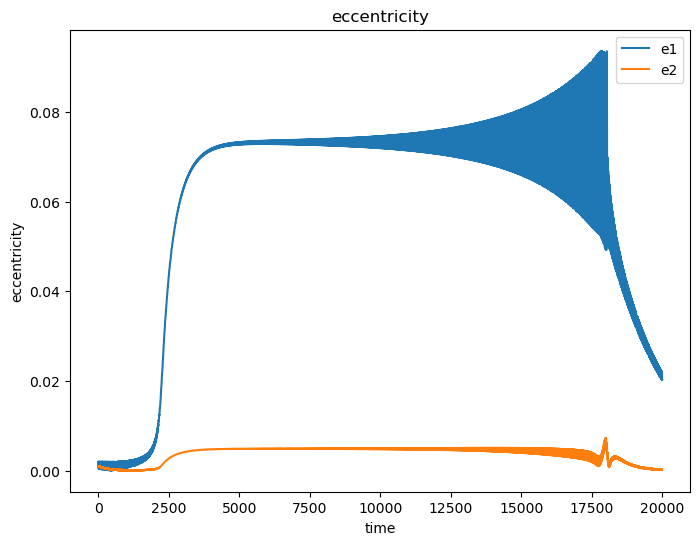

In [7]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
# ax.set_ylim([-1.5,2.5])
plt.title("eccentricity")
plt.xlabel("time")
plt.ylabel("eccentricity")
plt.plot(t/yr, sol[:, 2], label='e1')
plt.plot(t/yr, sol[:, 3], label='e2')
plt.legend()
plt.show()

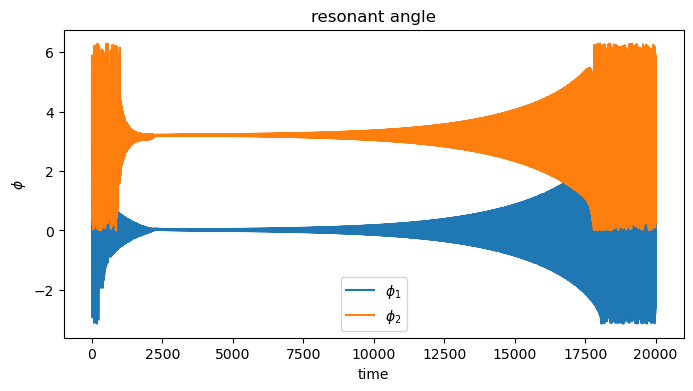

In [10]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
# ax.set_ylim([-1.5,2.5])
plt.title(r"resonant angle")
plt.xlabel("time")
plt.ylabel(r"$\phi$")
plt.plot(t/yr, (np.pi+sol[:, 6]-sol[:, 4])%(2*np.pi)-np.pi, label=r'$\phi_1$')
plt.plot(t/yr, (sol[:, 6]-sol[:, 5])%(2*np.pi), label=r'$\phi_2$')
plt.legend()
plt.show()

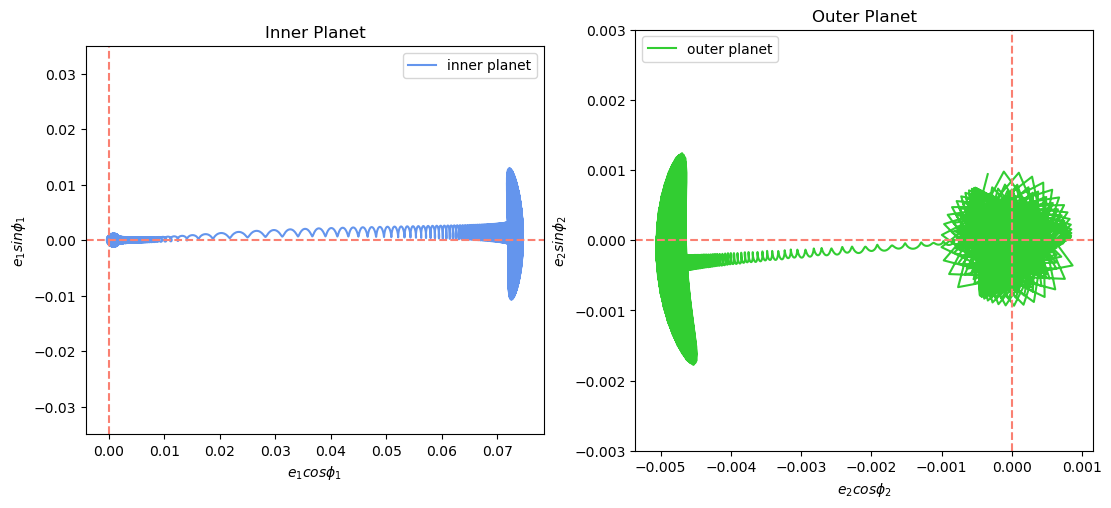

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
ax1.set_aspect('equal')
ax1.set_title('Inner Planet')
ax1.set_xlabel(r"$e_1cos\phi_1$")
ax1.set_ylabel(r"$e_1sin\phi_1$")
# ax1.set_xlim([-0.035, 0.035])
ax1.set_ylim([-0.035, 0.035])
ax1.plot((sol[0:10000, 2])*np.cos(sol[0:10000, 6]-sol[0:10000, 4]), (sol[0:10000, 2])*np.sin(sol[0:10000, 6]-sol[0:10000, 4]), c='cornflowerblue', label='inner planet')
ax1.axhline(y=0, linestyle='--', color='salmon')
ax1.axvline(x=0, linestyle='--', color='salmon')
ax1.legend()

ax2.set_aspect('equal')
ax2.set_title('Outer Planet')
ax2.set_xlabel(r"$e_2cos\phi_2$")
ax2.set_ylabel(r"$e_2sin\phi_2$")
# ax2.set_xlim([-0.005, 0.005])
ax2.set_ylim([-0.003, 0.003])
ax2.plot((sol[0:12000, 3])*np.cos((sol[0:12000, 6]-sol[0:12000, 5])), (sol[0:12000, 3])*np.sin((sol[0:12000, 6]-sol[0:12000, 5])), c='limegreen', label='outer planet')
ax2.axhline(y=0, linestyle='--', color='salmon')
ax2.axvline(x=0, linestyle='--', color='salmon')
ax2.legend()


REBOUND
--

In [18]:
sim = rebound.Simulation()
sim.integrator = "ias15"
# sim.ri_ias15.epsilon=0
sim.units = ('m', 's', 'kg')
sim.G = 6.674e-11 # SI units
sim.dt = 1e1 # Initial timestep in sec.
# sim.N_active = 3 # Make it 2 so dust particles don't interact with one another gravitationally


mu1 = 9.7e-6
mu2 = 4.8e-5
m1 = mu1*mstar
m2 = mu2*mstar
a1 = 0.11 * AU_To_Meter
a2 = 0.18 * AU_To_Meter

sim.add(m=mstar, hash="Star") # add Sun with mass in kg
sim.add(m=m1, a=a1, hash="Planet_1")
sim.move_to_com()
sim.add(m=m2, a=a2, hash="Planet_2")



ps = sim.particles

sim.status()

---------------------------------
REBOUND version:     	3.24.0
REBOUND built on:    	Mar 28 2023 02:54:30
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	10.000000
---------------------------------
<rebound.particle.Particle object at 0x7fe183094fc0, m=6.169e+29 x=-159621.65166997878 y=0.0 z=0.0 vx=0.0 vy=-0.4851856805313849 vz=0.0>
<rebound.particle.Particle object at 0x7fe183095740, m=5.98393e+24 x=16455840378.34833 y=0.0 z=0.0 vx=0.0 vy=50019.14232282319 vz=0.0>
<rebound.particle.Particle object at 0x7fe183094fc0, m=2.96112e+25 x=26928000000.0 y=0.0 z=0.0 vx=0.0 vy=39103.07995876342 vz=0.0>
---------------------------------


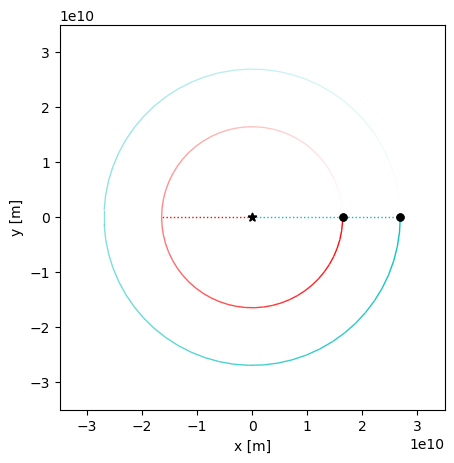

In [19]:
op = rebound.OrbitPlot(sim, unitlabel="[m]", color=True, periastron=True)

In [20]:
rebx = reboundx.Extras(sim)
# mod = rebx.load_operator("modify_orbits_direct") # direct force
# rebx.add_operator(mod)
mof = rebx.load_force("modify_orbits_forces") # orbit-averaged
rebx.add_force(mof)

In [23]:
tau_n1 = 2e5 * yr # in [s]
tau_n2 = 4e4 * yr # in [s]
tau_e1 = tau_n1/100.
tau_e2 = tau_n2/100.

ps["Planet_1"].params["tau_a"] = -1.5 * tau_n1
ps["Planet_1"].params["tau_e"] = -tau_e1
ps["Planet_2"].params["tau_a"] = -1.5 * tau_n2
ps["Planet_2"].params["tau_e"] = -tau_e2


Hamiltonian
--


$H_1 = -\frac{G(m_*+m_2)}{a_1} - n_2\sqrt{G(m_*+m_2)a_1(1-e_1^2)} - R_1$

$R_1 = \frac{Gm_2}{a_2}(be_1\cos{\phi_1}+ce_2\cos{\phi_2}+de_1^2\cos{2\phi_1}+fe_2^2\cos{2\phi_2})$


$H_2 = -\frac{G(m_*+m_1)}{a_2} - n_1\sqrt{G(m_*+m_1)a_2(1-e_2^2)} - R_2$

$R_2 = \frac{Gm_1}{a_2}(be_1\cos{\phi_1}+ce_2\cos{\phi_2}+de_1^2\cos{2\phi_1}+fe_2^2\cos{2\phi_2})$


In [25]:
def get_H_sim(sim):
    
    a1, a2 = ps['Planet_1'].a, ps['Planet_2'].a
    e1, e2 = ps['Planet_1'].e, ps['Planet_2'].e
    n1, n2 = ps['Planet_1'].n, ps['Planet_2'].n
    phi1 = 2*ps['Planet_2'].l -  ps['Planet_1'].l - ps['Planet_1'].pomega
    phi2 = 2*ps['Planet_2'].l -  ps['Planet_1'].l - ps['Planet_2'].pomega
    
    H10 = -0.5*G*(mstar+m2)/a1
    R1 = G*m2/a2*(b*e1*np.cos(phi1)+c*e2*np.cos(phi2)+d*e1**2*np.cos(2*phi1)+f*e2**2*np.cos(2*phi2))
    H1_sim = H10 - R1 - n2*np.sqrt(G*(mstar+m2)*a1*(1-e1**2))
    
    H20 = -0.5*G*(mstar+m1)/a2
    R2 = G*m1/a2*(b*e1*np.cos(phi1)+c*e2*np.cos(phi2)+d*e1**2*np.cos(2*phi1)+f*e2**2*np.cos(2*phi2))
    H2_sim = H20 - R2 - n1*np.sqrt(G*(mstar+m1)*a2*(1-e2**2))
    
    # Hamiltonian from Batygin 2015
    H_sim = -0.5*G*mstar*m1/a1 - 0.5*G*mstar*m2/a2 - G*m1*m2/a2 * (b*e1*np.cos(phi1)+c*e2*np.cos(phi2)+d*e1**2*np.cos(2*phi1)+f*e2**2*np.cos(2*phi2))

    return H1_sim, H2_sim, H_sim


In [26]:
%%time

yr = 365*24*3600 # s

Noutput = 5000
times = np.linspace(0, 20000*yr, Noutput)

e_1, a_1, n_1, kappa_1, resonant_angle_1 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e_2, a_2, n_2, kappa_2, resonant_angle_2 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
H1, H2, H_full = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)


for i, time in enumerate(times):
    sim.integrate(time)
    
    e_1[i], a_1[i], n_1[i] = ps["Planet_1"].e, ps["Planet_1"].a, ps["Planet_1"].n
    resonant_angle_1[i] = 2*ps["Planet_2"].l -  ps['Planet_1'].l - ps['Planet_1'].pomega
    e_2[i], a_2[i], n_2[i] = ps["Planet_2"].e, ps["Planet_2"].a, ps["Planet_2"].n
    resonant_angle_2[i] = 2*ps["Planet_2"].l -  ps['Planet_1'].l - ps['Planet_2'].pomega
    kappa_2[i] = np.sqrt(G*(mstar+m1)*a_2[i])*(1-2*np.sqrt(1-e_2[i]**2))

    H1[i], H2[i], H_full[i] = get_H_sim(sim)


CPU times: user 2min 51s, sys: 529 ms, total: 2min 51s
Wall time: 2min 51s


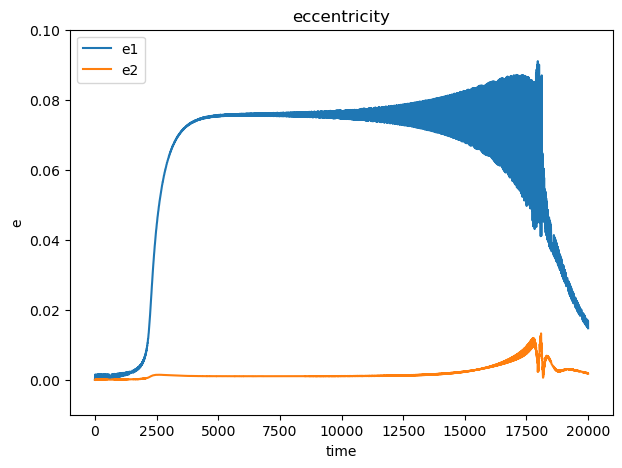

In [29]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
# ax.set_xlim([0,2000])
ax.set_ylim([-0.01, 0.1])
plt.title("eccentricity")
plt.xlabel("time")
plt.ylabel("e")
plt.plot(times/yr, e_1, label='e1')
plt.plot(times/yr, e_2, label='e2')
plt.legend()
plt.show()

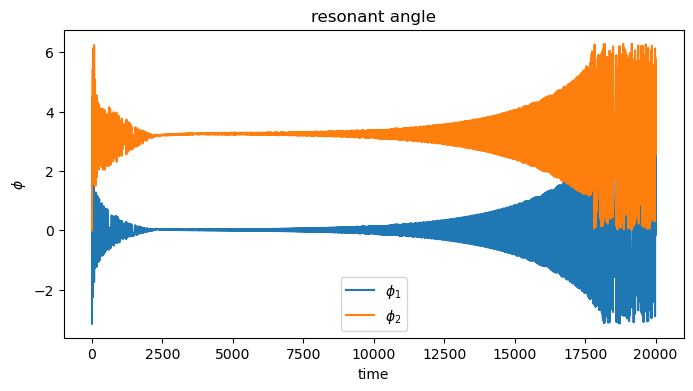

In [30]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
# ax.set_xlim([3500,4500])
# ax.set_ylim([-1.5,2.5])
plt.title("resonant angle")
plt.xlabel("time")
plt.ylabel(r"$\phi$")
plt.plot(times/yr, (np.pi+resonant_angle_1)%(2*np.pi)-np.pi, label=r'$\phi_1$')
plt.plot(times/yr, resonant_angle_2%(2*np.pi), label=r'$\phi_2$')
plt.legend()
plt.show()

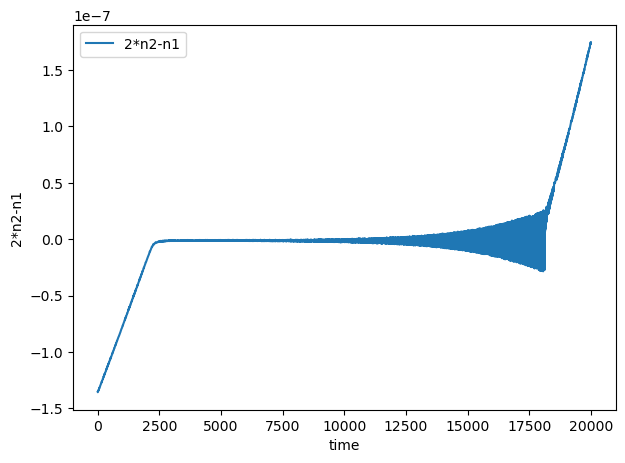

In [32]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
# ax.set_ylim([-1.5,2.5])
# plt.title("")
plt.xlabel("time")
plt.ylabel("2*n2-n1")
plt.plot(times/yr, 2*n_2-n_1, label='2*n2-n1')
plt.legend()
plt.show()

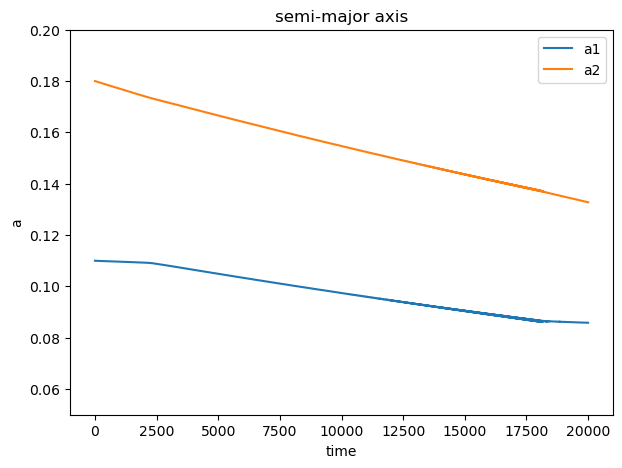

In [35]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
ax.set_ylim([0.05, 0.2])
plt.title("semi-major axis")
plt.xlabel("time")
plt.ylabel("a")
plt.plot(times/yr, a_1/AU_To_Meter, label='a1')
plt.plot(times/yr, a_2/AU_To_Meter, label='a2')
plt.legend()
plt.show()

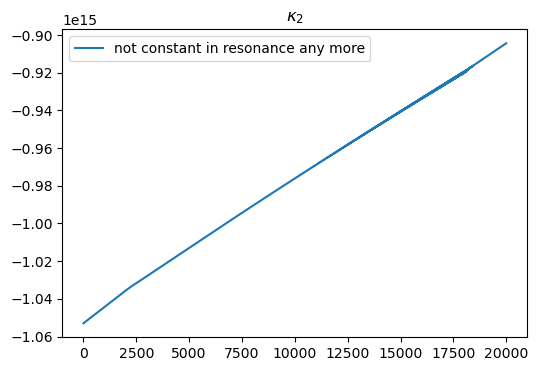

In [38]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
plt.title(r"$\kappa_2$")
# ax.set_xlim(0, 125)
# ax.set_ylim([-5.442e10, -5.425e10])
plt.plot(times/yr, kappa_2, label = 'not constant in resonance any more')
plt.legend()
plt.show()

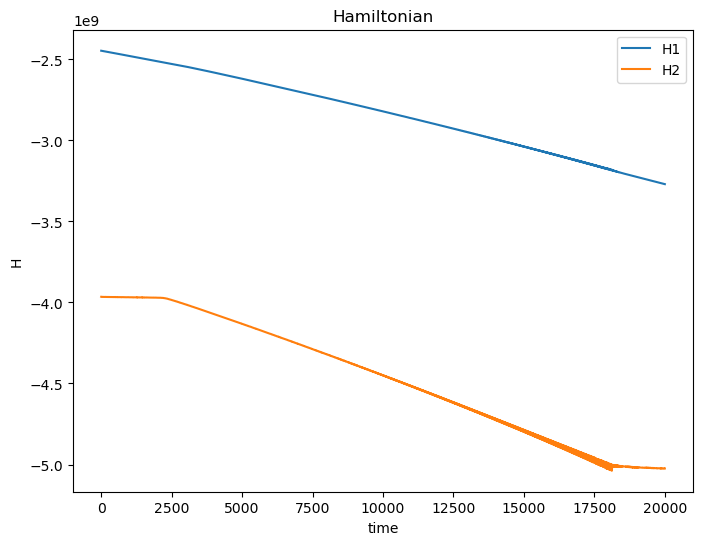

In [39]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
# ax.set_ylim([0.05, 0.2])
plt.title("Hamiltonian")
plt.xlabel("time")
plt.ylabel("H")
plt.plot(times/yr, H1, label='H1')
plt.plot(times/yr, H2, label='H2')
# plt.plot(times/yr, H_full, label='H_full')
plt.legend()
plt.show()

phase space
--

In [40]:
ecosphi1 = e_1*np.cos(resonant_angle_1)
esinphi1 = e_1*np.sin(resonant_angle_1)

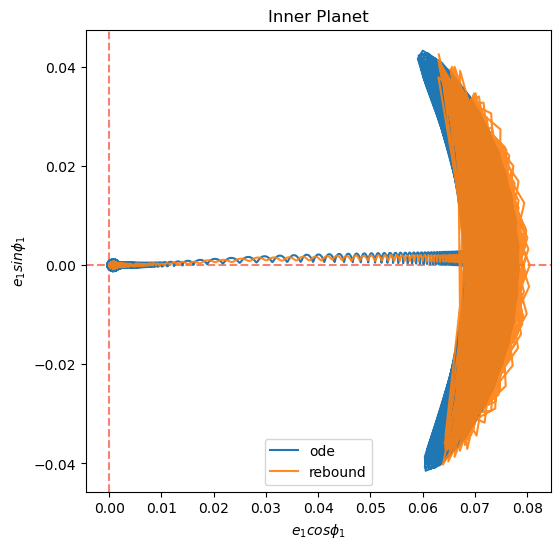

In [68]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.03, 0.03])
plt.title('Inner Planet')
plt.xlabel(r"$e_1cos\phi_1$")
plt.ylabel(r"$e_1sin\phi_1$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')


plt.plot((sol[0:14000, 2])*np.cos(sol[0:14000, 6]-sol[0:14000, 4]), (sol[0:14000, 2])*np.sin(sol[0:14000, 6]-sol[0:14000, 4]), label='ode')
plt.plot(ecosphi1[0:3500], esinphi1[0:3500], alpha = 0.9, label='rebound')
plt.legend()
plt.show()

In [70]:
ecosphi2 = e_2*np.cos(resonant_angle_2)
esinphi2 = e_2*np.sin(resonant_angle_2)

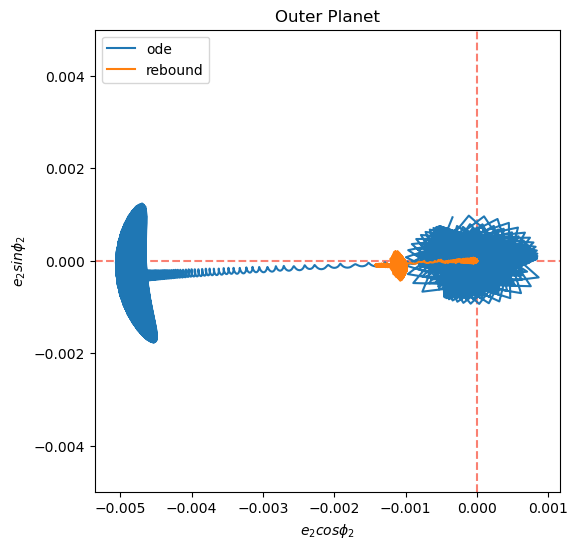

In [85]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
# ax.set_xlim([-0.005, 0.005])
ax.set_ylim([-0.005, 0.005])
plt.title('Outer Planet')
plt.xlabel(r"$e_2cos\phi_2$")
plt.ylabel(r"$e_2sin\phi_2$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')
plt.plot((sol[0:12000, 3])*np.cos(sol[0:12000, 6]-sol[0:12000, 5]), (sol[0:12000, 3])*np.sin(sol[0:12000, 6]-sol[0:12000, 5]), label='ode')
plt.plot(ecosphi2[0:3000], esinphi2[0:3000], label='rebound')
plt.legend()
plt.show()

level curves of Jacobi constant
--

In [87]:
Ngrid = 100
e2_grid = np.linspace(0, 0.02, Ngrid)
phi2_grid = np.linspace(0, 2*np.pi, Ngrid)

ecosphi_grid, esinphi_grid = [], []

for i in range(Ngrid):
    for j in range(Ngrid):
        ecosphi_grid.append(e2_grid[i]*np.cos(phi2_grid[j]))
        esinphi_grid.append(e2_grid[i]*np.sin(phi2_grid[j]))

X = np.reshape([(e2_*np.cos(phi2_)) for e2_ in e2_grid for phi2_ in phi2_grid],(Ngrid,Ngrid))
Y = np.reshape([(e2_*np.sin(phi2_)) for e2_ in e2_grid for phi2_ in phi2_grid],(Ngrid,Ngrid))


# X_, Y_ = np.meshgrid(e2_grid*np.cos(phi2_grid), e2_grid*np.sin(phi2_grid))


In [88]:
get_a2 = lambda e2, kappa: (kappa/(1-2*np.sqrt(1-e2**2)))**2/(mu1+mu2)

def get_H2_grid(e2, phi2, i):
    
    a2 = get_a2(e2, kappa_2[i])
    
    H20 = -0.5*G*(mstar+m1)/a2
    R2 = G*m1/a2*(b*e_1[i]*np.cos(resonant_angle_1[i])+c*e2*np.cos(phi2)+d*e_1[i]**2*np.cos(2*resonant_angle_1[i])+f*e2**2*np.cos(2*phi2))
    H2_grid = H20 - np.sqrt(G*m1/a_1[i]**3)*np.sqrt(G*(m1+m2)*a2*(1-e2**2)) - R2
              
    return H2_grid


In [89]:
%%time

H2_grid = []

for i_ in range(Noutput):
    H2_grid.append(np.reshape([get_H2_grid(e2_, phi2_, i) for e2_ in e2_grid for phi2_ in phi2_grid],(Ngrid,Ngrid)))


CPU times: user 7min 9s, sys: 972 ms, total: 7min 10s
Wall time: 7min 10s


In [90]:
# find local maxima/minima

ind=3000

X_max, Y_max = [], []
X_min, Y_min = [], []


for i in range(1, len(X)-1):
    for j in range(1, len(Y)-1):
        if ((H2_grid[ind][i, j]>H2_grid[ind][i-1, j]) & (H2_grid[ind][i, j]>H2_grid[ind][i+1, j])
        & (H2_grid[ind][i, j]>H2_grid[ind][i, j-1]) & (H2_grid[ind][i, j]>H2_grid[ind][i, j+1])
           & (H2_grid[ind][i, j]>H2_grid[ind][i-1, j-1]) & (H2_grid[ind][i, j]>H2_grid[ind][i+1, j+1])):
#             print ("local maxima:", i, j)
            X_max.append(X[i, j])
            Y_max.append(Y[i, j])
            
        if ((H2_grid[ind][i, j]<H2_grid[ind][i-1, j]) & (H2_grid[ind][i, j]<H2_grid[ind][i+1, j])
        & (H2_grid[ind][i, j]<H2_grid[ind][i, j-1]) & (H2_grid[ind][i, j]<H2_grid[ind][i, j+1])
           & (H2_grid[ind][i, j]<H2_grid[ind][i-1, j-1]) & (H2_grid[ind][i, j]<H2_grid[ind][i+1, j+1])):
#             print ("local minima:", i, j)
            X_min.append(X[i, j])
            Y_min.append(Y[i, j])
            
    
        

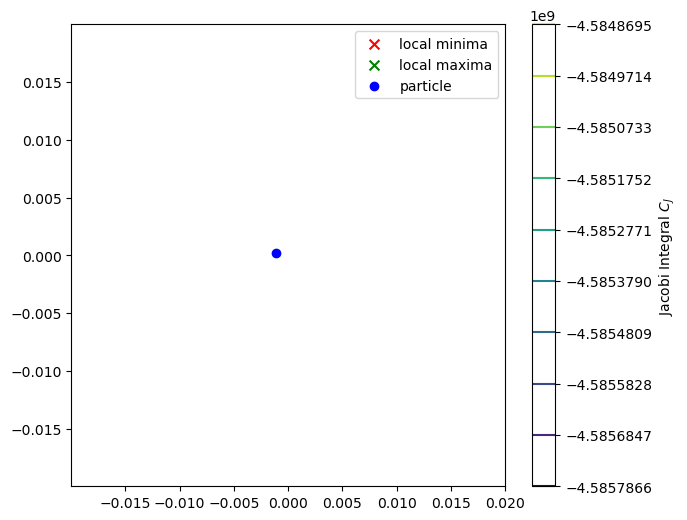

In [91]:
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111)
# ax.set_xlim(-0.005, 0.005)
# ax.set_ylim(-0.005, 0.005)
index = ind
levels = np.linspace(1.0001*H2[index], 0.9999*H2[index], 10)
color_map = plt.colormaps.get_cmap('YlGnBu')
plt.contour(X, Y, H2_grid[index], levels)
plt.colorbar().set_label('Jacobi Integral $C_J$')
plt.scatter(X_max, Y_max, s=50, marker='x', c='r', label='local minima')
plt.scatter(X_min, Y_min, s=50, marker='x', c='g', label='local maxima')
plt.scatter(ecosphi2[index], esinphi2[index], c='b', label='particle')
plt.legend()


In [ ]:
from IPython.display import HTML

HTML(ani.to_html5_video())